In [1]:
from __future__ import division
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
import math
import sklearn as skl
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_fscore_support

In [2]:
# LOADING DATA

train_data = pd.read_csv('/Users/romainolekhnovitch/Desktop/testDataiku/us_census_full/census_income_learn.csv')
test_data = pd.read_csv('/Users/romainolekhnovitch/Desktop/testDataiku/us_census_full/census_income_test.csv')

# Here we take only into acount the variables that are indeed in the csv file
train_data.columns = ['AAGE', 'ACLSWKR', 'ADTIND', 'ADTOCC', 'AHGA', 'AHRSPAY', 'AHSCOL', 'AMARITL', 'AMJIND', 'AMJOCC', 'ARACE', 'AREORGN', 'ASEX', 'AUNMEM', 'AUNTYPE', 'AWKSTAT', 'CAPGAIN', 'CAPLOSS', 'DIVVAL', 'FILESTAT', 'GRINREG', 'GRINST', 'HHDFMX', 'HHDREL', 'MARSUPWT', 'MIGMTR1', 'MIGMTR3', 'MIGMTR4', 'MIGSAME', 'MIGSUN', 'NOEMP', 'PARENT', 'PEFNTVTY', 'PEMNTVTY', 'PENATVTY', 'PRCITSHP', 'SEOTR', 'VETQVA', 'VETYN', 'WKSWORK', 'YEAR', 'PTOTVAL']
test_data.columns = ['AAGE', 'ACLSWKR', 'ADTIND', 'ADTOCC', 'AHGA', 'AHRSPAY', 'AHSCOL', 'AMARITL', 'AMJIND', 'AMJOCC', 'ARACE', 'AREORGN', 'ASEX', 'AUNMEM', 'AUNTYPE', 'AWKSTAT', 'CAPGAIN', 'CAPLOSS', 'DIVVAL', 'FILESTAT', 'GRINREG', 'GRINST', 'HHDFMX', 'HHDREL', 'MARSUPWT', 'MIGMTR1', 'MIGMTR3', 'MIGMTR4', 'MIGSAME', 'MIGSUN', 'NOEMP', 'PARENT', 'PEFNTVTY', 'PEMNTVTY', 'PENATVTY', 'PRCITSHP', 'SEOTR', 'VETQVA', 'VETYN', 'WKSWORK', 'YEAR', 'PTOTVAL']

train_data['OUT'] = (train_data.PTOTVAL == ' 50000+.').astype(int)
test_data['OUT'] = (test_data.PTOTVAL == ' 50000+.').astype(int)

train_data = train_data[train_data.AAGE >= 16]
test_data = test_data[test_data.AAGE >= 16]

In [3]:
# REORGANIZING DATA: separating continuous and nominal variables (nominal variables encoded by integers are put first)

# regrouping continuous variables
train_data_cont = train_data[['AAGE', 'AHRSPAY', 'CAPGAIN', 'CAPLOSS', 'DIVVAL', 'NOEMP', 'WKSWORK']]

# regrouping nominal variables (we put the integer-encoded variables first and deleted the PTOTVAL variables (which is the output) and the MARSUPWT variables (which encodes the frequency of the instance weight that we chose to ignore --> can we take it into acount later ?))
train_data_nom = train_data[['ADTIND', 'ADTOCC', 'SEOTR', 'VETYN', 'YEAR', 'ACLSWKR', 'AHGA', 'AHSCOL', 'AMARITL', 'AMJIND', 'AMJOCC', 'ARACE', 'AREORGN', 'ASEX', 'AUNMEM', 'AUNTYPE', 'AWKSTAT', 'FILESTAT', 'GRINREG', 'GRINST', 'HHDFMX', 'HHDREL', 'MIGMTR1', 'MIGMTR3', 'MIGMTR4', 'MIGSAME', 'MIGSUN', 'PARENT', 'PEFNTVTY', 'PEMNTVTY', 'PENATVTY', 'PRCITSHP', 'VETQVA']]

n_cont = len(train_data_cont.columns)
n_nom = len(train_data_nom.columns)
n_row = len(train_data_nom.index)
print n_cont, n_nom, n_row

train_X = pd.concat([train_data_cont, train_data_nom], axis=1)

# doing the same for test dataset
test_data_cont = test_data[['AAGE', 'AHRSPAY', 'CAPGAIN', 'CAPLOSS', 'DIVVAL', 'NOEMP', 'WKSWORK']]
test_data_nom = test_data[['ADTIND', 'ADTOCC', 'SEOTR', 'VETYN', 'YEAR', 'ACLSWKR', 'AHGA', 'AHSCOL', 'AMARITL', 'AMJIND', 'AMJOCC', 'ARACE', 'AREORGN', 'ASEX', 'AUNMEM', 'AUNTYPE', 'AWKSTAT', 'FILESTAT', 'GRINREG', 'GRINST', 'HHDFMX', 'HHDREL', 'MIGMTR1', 'MIGMTR3', 'MIGMTR4', 'MIGSAME', 'MIGSUN', 'PARENT', 'PEFNTVTY', 'PEMNTVTY', 'PENATVTY', 'PRCITSHP', 'VETQVA']]

n_cont_test = len(test_data_cont.columns)
n_nom_test = len(test_data_nom.columns)
n_row_test = len(test_data_nom.index)

print n_cont_test, n_nom_test, n_row_test

test_X = pd.concat([test_data_cont, test_data_nom], axis=1)

7 33 149174
7 33 74860


                AAGE        AHRSPAY        CAPGAIN        CAPLOSS  \
count  149174.000000  149174.000000  149174.000000  149174.000000   
mean       43.621154      74.001998     581.428808      49.637604   
std        18.128851     315.655801    5424.896420     312.617181   
min        16.000000       0.000000       0.000000       0.000000   
25%        29.000000       0.000000       0.000000       0.000000   
50%        41.000000       0.000000       0.000000       0.000000   
75%        56.000000       0.000000       0.000000       0.000000   
max        90.000000    9999.000000   99999.000000    4608.000000   

              DIVVAL         NOEMP        WKSWORK  
count  149174.000000  149174.00000  149174.000000  
mean      264.190181       2.60595      30.919946  
std      2290.868871       2.40186      23.596489  
min         0.000000       0.00000       0.000000  
25%         0.000000       0.00000       0.000000  
50%         0.000000       2.00000      48.000000  
75%         0.

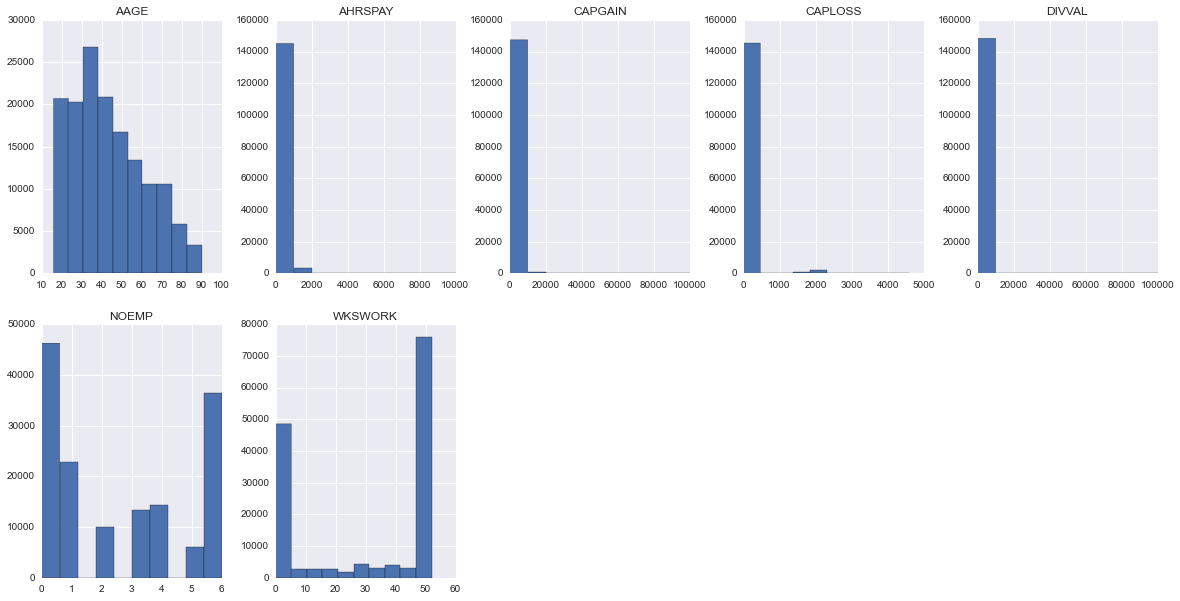

In [4]:
# PLOTTING CONTINUOUS VARIABLES

print train_data_cont.describe()

fig = plt.figure(figsize=(20,10))
cols = 5
rows = (n_cont // cols) + 1
for i in xrange(n_cont):
    fig.add_subplot(rows, cols, i + 1)
    train_data_cont.ix[:, i].hist()
    plt.title(train_data_cont.columns[i])
plt.subplots_adjust(hspace=0.2, wspace=0.3)

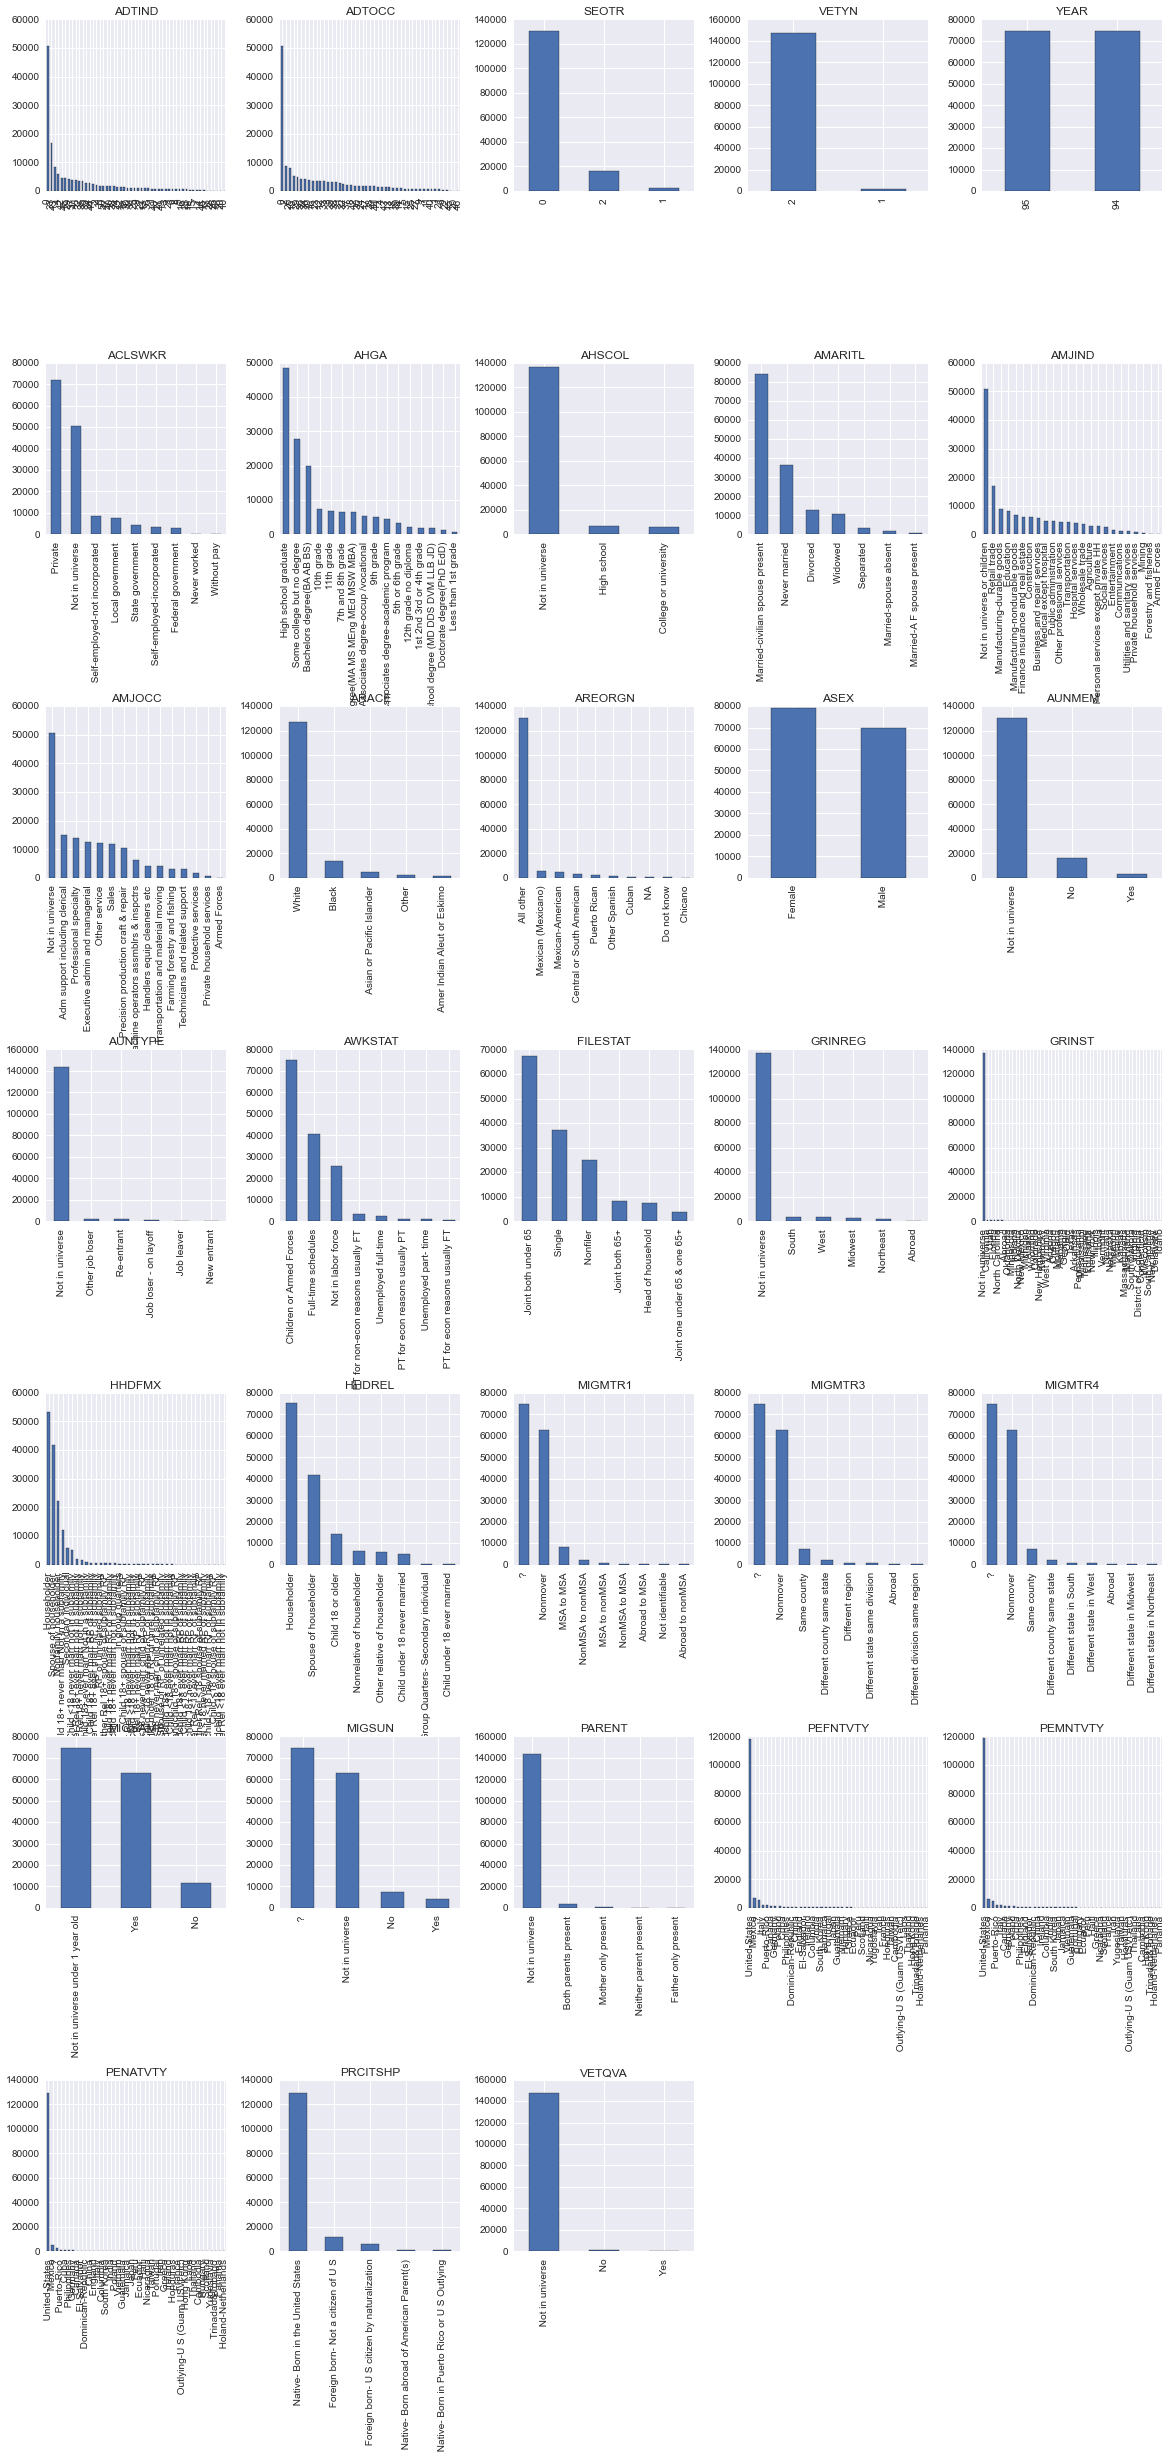

In [5]:
# PLOTTING NOMINAL VARIABLES

fig = plt.figure(figsize=(20,40))
cols = 5
rows = (n_nom // cols) + 1
for i in xrange(n_nom):
    fig.add_subplot(rows, cols, i + 1)
    train_data_nom.ix[:, i].value_counts().plot(kind='bar')
    plt.title(train_data_nom.columns[i])
plt.subplots_adjust(hspace=1, wspace=0.3)


In [6]:
# PLOTTING % OF MISSING VALUES (NOMINAL VARIABLES)

# we use the str.contains function to detect 'Not in universe' occurence (I could not manage to detect '?' occurence with the same function..)
missing_val = {}
for col in train_data_nom.columns:
    if train_data_nom.dtypes[col] == np.object:
        var = train_data_nom[col].str.contains('Not in universe').sum()
        var /= n_row
        missing_val[col] = var
    else:
        missing_val[col] = 0.0
print missing_val

{'ASEX': 0.0, 'GRINST': 0.92068993256197462, 'AMARITL': 0.0, 'MIGSAME': 0.50048265783581591, 'PEFNTVTY': 0.0, 'HHDFMX': 0.0, 'PRCITSHP': 0.0, 'VETQVA': 0.986700095190851, 'PEMNTVTY': 0.0, 'MIGMTR3': 0.0, 'AUNMEM': 0.87257162776355124, 'MIGMTR1': 0.0, 'MIGMTR4': 0.0, 'ARACE': 0.0, 'ACLSWKR': 0.33737782723530912, 'VETYN': 0.0, 'PARENT': 0.96390791961065603, 'HHDREL': 0.0, 'FILESTAT': 0.0, 'MIGSUN': 0.42020727472615871, 'YEAR': 0.0, 'AHSCOL': 0.9156756539343317, 'AMJIND': 0.3400257417512435, 'AREORGN': 0.0, 'AUNTYPE': 0.95986566023569786, 'AMJOCC': 0.3400257417512435, 'ADTOCC': 0.0, 'ADTIND': 0.0, 'GRINREG': 0.92068993256197462, 'AHGA': 0.0, 'SEOTR': 0.0, 'AWKSTAT': 0.0, 'PENATVTY': 0.0}


In [7]:
# DROPPING VARIABLES WITH HIGH MISSING VALUES FREQUENCY
train_data_nom_bis = train_data_nom.drop(['GRINST', 'VETQVA', 'PARENT', 'AHSCOL', 'AUNTYPE', 'GRINREG'], axis=1)
test_data_nom_bis = test_data_nom.drop(['GRINST', 'VETQVA', 'PARENT', 'AHSCOL', 'AUNTYPE', 'GRINREG'], axis=1)

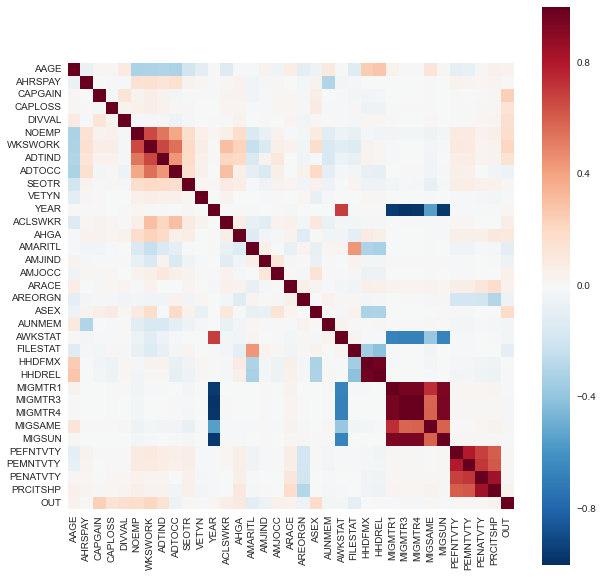

In [8]:
# INVESTIGATING VARIABLES CORRELATIONS

# First we transform category objects in nominal variables into integers
train_data_nom_bis_le = train_data_nom_bis.copy()
for col in train_data_nom_bis.columns:
    if train_data_nom_bis.dtypes[col] == np.object:
        le = skl.preprocessing.LabelEncoder()
        train_data_nom_bis_le[col] = le.fit_transform(train_data_nom_bis_le[col])

# We concatenate with continuous variables
train_resume = pd.concat([train_data_cont, train_data_nom_bis_le, train_data.OUT], axis=1)
        
# We plot the correlation heatmap
fig = plt.figure(figsize=(10,10))
sns.heatmap(train_resume.corr(), square=True)
plt.show()

In [9]:
# DROPPING REDUNDANT VARIABLES
train_data_nom_ok = train_data_nom_bis.drop(['HHDFMX', 'MIGMTR3', 'MIGMTR4', 'MIGSUN', 'PEMNTVTY', 'PENATVTY', 'YEAR'], axis=1)
test_data_nom_ok = test_data_nom_bis.drop(['HHDFMX', 'MIGMTR3', 'MIGMTR4', 'MIGSUN', 'PEMNTVTY', 'PENATVTY', 'YEAR'], axis=1)

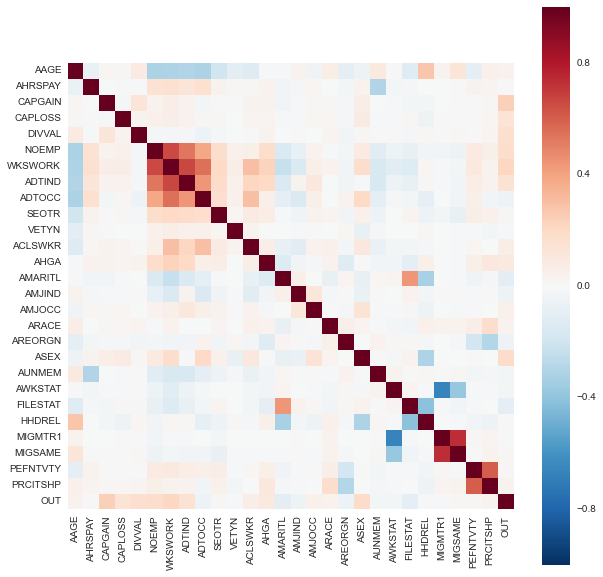

In [10]:
# PLOTTING VARIABLES CORRELATIONS

train_data_nom_ok_le = train_data_nom_ok.copy()
for col in train_data_nom_ok.columns:
    if train_data_nom_ok.dtypes[col] == np.object:
        le = skl.preprocessing.LabelEncoder()
        train_data_nom_ok_le[col] = le.fit_transform(train_data_nom_ok_le[col])

train_resume = pd.concat([train_data_cont, train_data_nom_ok_le, train_data.OUT], axis=1)
        
fig = plt.figure(figsize=(10,10))
sns.heatmap(train_resume.corr(), square=True)
plt.show()

In [11]:
# CONTINUOUS VARIABLES --> TRAINING (we test classification strategies on continuous and nominal variables separately to see if some stragegies are best suited to a specific type of variables)

train_data_cont_int = train_data_cont[:50000]
y_train = train_data.OUT[:50000]

# selecting the 5 variables that are best correlated to the output with a chi2 test
chi2filter_cont = SelectKBest(chi2, k=5)
chi2filter_cont.fit(train_data_cont_int, y_train)
chi2filter_cont_index = chi2filter_cont.get_support(indices=True)

# Normalizing data
scaler = skl.preprocessing.StandardScaler()
trainX_cont = pd.DataFrame(scaler.fit_transform(train_data_cont_int), columns=train_data_cont_int.columns)

# logistic regression with l1 regularization
logregl1_cont = LogisticRegression(C = 0.1, penalty='l1', tol=0.001)
logregl1_cont.fit(trainX_cont, y_train)
precision, recall, f1score, _ = precision_recall_fscore_support(y_train, logregl1_cont.predict(trainX_cont))
print 'Logistic regression l1: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])

# logistic regression with l2 regularization
logregl2_cont = LogisticRegression(C = 0.1, penalty='l2', tol=0.001)
logregl2_cont.fit(trainX_cont, y_train)
precision, recall, f1score, _ = precision_recall_fscore_support(y_train, logregl2_cont.predict(trainX_cont))
print 'Logistic regression l2: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])

# logistic regression on the 5 best correlated variables
trainX_cont_bestchi2 = trainX_cont.iloc[:, chi2filter_cont_index]
logreg_cont_bestchi2 = LogisticRegression(C = 0.1, penalty='l1', tol=0.001)
logreg_cont_bestchi2.fit(trainX_cont_bestchi2, y_train)
precision, recall, f1score, _ = precision_recall_fscore_support(y_train, logreg_cont_bestchi2.predict(trainX_cont_bestchi2))
print 'Logistic regression with best chi2: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])

# logistic regression on a pca with 5 components
pca_cont = PCA(n_components=5)
trainX_cont_pca = pca_cont.fit_transform(trainX_cont)
logreg_cont_pca = LogisticRegression(C = 0.1, penalty='l1', tol=0.001)
logreg_cont_pca.fit(trainX_cont_pca, y_train)
precision, recall, f1score, _ = precision_recall_fscore_support(y_train, logreg_cont_pca.predict(trainX_cont_pca))
print 'Logistic regression with pca: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])

# logistic regression with polynomial variables (degree 2)
poly = skl.preprocessing.PolynomialFeatures(degree=2)
trainX_cont_pol = poly.fit_transform(trainX_cont)
logreg_cont_pol = LogisticRegression(C = 0.1, penalty='l1', tol=0.001)
logreg_cont_pol.fit(trainX_cont_pol, y_train)
precision, recall, f1score, _ = precision_recall_fscore_support(y_train, logreg_cont_pol.predict(trainX_cont_pol))
print 'Logistic regression with PolynomialFeatures: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])

# random forest
randfor_cont = RandomForestClassifier(n_estimators=100)
randfor_cont.fit(trainX_cont, y_train)
precision, recall, f1score, _ = precision_recall_fscore_support(y_train, randfor_cont.predict(trainX_cont))
print 'Random forest: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])

# random forest with oob score
randfor_cont_oob = RandomForestClassifier(n_estimators=100, oob_score=True)
randfor_cont_oob.fit(trainX_cont, y_train)
precision, recall, f1score, _ = precision_recall_fscore_support(y_train, randfor_cont_oob.predict(trainX_cont))
print 'Random forest with oob scores: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])


Logistic regression l1: precision = 0.780022, recall = 0.169885, f1score = 0.279004
Logistic regression l2: precision = 0.779148, recall = 0.169885, f1score = 0.278948
Logistic regression with best chi2: precision = 0.826948, recall = 0.153019, f1score = 0.258251
Logistic regression with pca: precision = 0.787529, recall = 0.166707, f1score = 0.275166
Logistic regression with PolynomialFeatures: precision = 0.763038, recall = 0.203862, f1score = 0.321759
Random forest: precision = 0.956383, recall = 0.584209, f1score = 0.725341
Random forest with oob scores: precision = 0.956035, recall = 0.584698, f1score = 0.725618


/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:498: UserWarning: StandardScaler assumes floating point values as input, got int64
  "got %s" % (estimator, X.dtype))


In [12]:
# CONTINUOUS VARIABLES --> TESTING

test_data_cont_int = test_data_cont
y_test = test_data.OUT

scaler = skl.preprocessing.StandardScaler()
testX_cont = pd.DataFrame(scaler.fit_transform(test_data_cont_int), columns=test_data_cont_int.columns)

testX_cont_bestchi2 = testX_cont.iloc[:, chi2filter_cont_index]

testX_cont_pca = pca_cont.transform(testX_cont)

poly = skl.preprocessing.PolynomialFeatures(degree=2)
testX_cont_pol = poly.fit_transform(testX_cont)

precision, recall, f1score, _ = precision_recall_fscore_support(y_test, logregl1_cont.predict(testX_cont))
print 'Logistic regression l1: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])
precision, recall, f1score, _ = precision_recall_fscore_support(y_test, logregl2_cont.predict(testX_cont))
print 'Logistic regression l2: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])
precision, recall, f1score, _ = precision_recall_fscore_support(y_test, logreg_cont_bestchi2.predict(testX_cont_bestchi2))
print 'Logistic regression with best chi2: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])
precision, recall, f1score, _ = precision_recall_fscore_support(y_test, logreg_cont_pca.predict(testX_cont_pca))
print 'Logistic regression with pca: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])
precision, recall, f1score, _ = precision_recall_fscore_support(y_test, logreg_cont_pol.predict(testX_cont_pol))
print 'Logistic regression with PolynomialFeatures: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])
precision, recall, f1score, _ = precision_recall_fscore_support(y_test, randfor_cont.predict(testX_cont))
print 'Random forest: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])
precision, recall, f1score, _ = precision_recall_fscore_support(y_test, randfor_cont_oob.predict(testX_cont))
print 'Random forest with oob scores: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])


Logistic regression l1: precision = 0.765255, recall = 0.172325, f1score = 0.281304
Logistic regression l2: precision = 0.763989, recall = 0.172163, f1score = 0.281003
Logistic regression with best chi2: precision = 0.803252, recall = 0.159715, f1score = 0.266451
Logistic regression with pca: precision = 0.770682, recall = 0.171678, f1score = 0.280804
Logistic regression with PolynomialFeatures: precision = 0.747919, recall = 0.203362, f1score = 0.319776
Random forest: precision = 0.590940, recall = 0.282574, f1score = 0.382327
Random forest with oob scores: precision = 0.592295, recall = 0.285807, f1score = 0.385563


In [13]:
# NOMINAL VARIABLES --> TRAINING

# creating dummy columns
dummies = pd.get_dummies(train_data_nom_ok, columns=train_data_nom_ok.columns)
train_data_nom_int = dummies[:10000]
y_train = train_data.OUT[:10000]

# selecting the 50 variables that are best correlated to the output with a chi2 test
chi2filter_nom = SelectKBest(chi2, k=50)
chi2filter_nom.fit(train_data_nom_int, y_train)
chi2filter_nom_index = chi2filter_nom.get_support(indices=True)

# Normalizing data
scaler = skl.preprocessing.StandardScaler()
trainX_nom = pd.DataFrame(scaler.fit_transform(train_data_nom_int), columns=train_data_nom_int.columns)

# applying the chi2filter on normalized data (the chi2filter can only be fitted on positive values thus cannot be fitted on the normalized dataset)
trainX_nom_bestchi2 = trainX_nom.iloc[:, chi2filter_nom_index]


# logistic regression with l1 regularization
logregl1_nom = LogisticRegression(C = 0.1, penalty='l1', tol=0.001)
logregl1_nom.fit(trainX_nom, y_train)
precision, recall, f1score, _ = precision_recall_fscore_support(y_train, logregl1_nom.predict(trainX_nom))
print 'Logistic regression l1: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])

# logistic regression with l2 regularization
logregl2_nom = LogisticRegression(C = 0.1, penalty='l2', tol=0.001)
logregl2_nom.fit(trainX_nom, y_train)
precision, recall, f1score, _ = precision_recall_fscore_support(y_train, logregl2_nom.predict(trainX_nom))
print 'Logistic regression l2: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])

# logistic regression on the 50 best correlated variables
trainX_nom_bestchi2 = trainX_nom.iloc[:, chi2filter_nom_index]
logreg_nom_bestchi2 = LogisticRegression(C = 0.1, penalty='l1', tol=0.001)
logreg_nom_bestchi2.fit(trainX_nom_bestchi2, y_train)
precision, recall, f1score, _ = precision_recall_fscore_support(y_train, logreg_nom_bestchi2.predict(trainX_nom_bestchi2))
print 'Logistic regression with best chi2: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])

# logistic regression on a pca with 50 components
pca_nom = PCA(n_components=50)
trainX_nom_pca = pca_nom.fit_transform(trainX_nom)
logreg_nom_pca = LogisticRegression(C = 0.1, penalty='l1', tol=0.001)
logreg_nom_pca.fit(trainX_nom_pca, y_train)
precision, recall, f1score, _ = precision_recall_fscore_support(y_train, logreg_nom_pca.predict(trainX_nom_pca))
print 'Logistic regression with pca: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])

# random forest
randfor_nom = RandomForestClassifier(n_estimators=100)
randfor_nom.fit(trainX_nom, y_train)
precision, recall, f1score, _ = precision_recall_fscore_support(y_train, randfor_nom.predict(trainX_nom))
print 'Random forest: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])

# random forest with oob score
randfor_nom_oob = RandomForestClassifier(n_estimators=100, oob_score=True)
randfor_nom_oob.fit(trainX_nom, y_train)
precision, recall, f1score, _ = precision_recall_fscore_support(y_train, randfor_nom_oob.predict(trainX_nom))
print 'Random forest with oob scores: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])

Logistic regression l1: precision = 0.718670, recall = 0.351690, f1score = 0.472269
Logistic regression l2: precision = 0.693023, recall = 0.372966, f1score = 0.484947
Logistic regression with best chi2: precision = 0.702350, recall = 0.336671, f1score = 0.455161
Logistic regression with pca: precision = 0.619835, recall = 0.281602, f1score = 0.387263
Random forest: precision = 0.986894, recall = 0.942428, f1score = 0.964149
Random forest with oob scores: precision = 0.992042, recall = 0.936170, f1score = 0.963297


In [14]:
# NOMINAL VARIABLES --> TESTING

dummies = pd.get_dummies(test_data_nom_ok, columns=test_data_nom_ok.columns)
test_data_nom_int = dummies
y_test = test_data.OUT

scaler = skl.preprocessing.StandardScaler()
testX_nom = pd.DataFrame(scaler.fit_transform(test_data_nom_int), columns=test_data_nom_int.columns)

testX_nom_bestchi2 = testX_nom.iloc[:, chi2filter_nom_index]

testX_nom_pca = pca_nom.transform(testX_nom)

precision, recall, f1score, _ = precision_recall_fscore_support(y_test, logregl1_nom.predict(testX_nom))
print 'Logistic regression l1: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])
precision, recall, f1score, _ = precision_recall_fscore_support(y_test, logregl2_nom.predict(testX_nom))
print 'Logistic regression l2: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])
precision, recall, f1score, _ = precision_recall_fscore_support(y_test, logreg_nom_bestchi2.predict(testX_nom_bestchi2))
print 'Logistic regression with best chi2: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])
precision, recall, f1score, _ = precision_recall_fscore_support(y_test, logreg_nom_pca.predict(testX_nom_pca))
print 'Logistic regression with pca: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])
precision, recall, f1score, _ = precision_recall_fscore_support(y_test, randfor_nom.predict(testX_nom))
print 'Random forest: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])
precision, recall, f1score, _ = precision_recall_fscore_support(y_test, randfor_nom_oob.predict(testX_nom))
print 'Random forest with oob scores: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])

Logistic regression l1: precision = 0.651000, recall = 0.300032, f1score = 0.410756
Logistic regression l2: precision = 0.620200, recall = 0.310702, f1score = 0.414001
Logistic regression with best chi2: precision = 0.645811, recall = 0.290333, f1score = 0.400580
Logistic regression with pca: precision = 0.640765, recall = 0.254607, f1score = 0.364415
Random forest: precision = 0.580307, recall = 0.268671, f1score = 0.367293
Random forest with oob scores: precision = 0.582957, recall = 0.270934, f1score = 0.369937


In [16]:
# TOTAL VARIABLES --> TRAINING

train_data_cont_int = train_data_cont[:50000]
dummies = pd.get_dummies(train_data_nom_ok, columns=train_data_nom_ok.columns)
train_data_nom_int = dummies[:50000]
y_train = train_data.OUT[:50000]

chi2filter_cont = SelectKBest(chi2, k=5)
chi2filter_cont.fit(train_data_cont_int, y_train)
chi2filter_cont_index = chi2filter_cont.get_support(indices=True)
chi2filter_nom = SelectKBest(chi2, k=50)
chi2filter_nom.fit(train_data_nom_int, y_train)
chi2filter_nom_index = chi2filter_nom.get_support(indices=True)

scaler = skl.preprocessing.StandardScaler()
trainX_cont = pd.DataFrame(scaler.fit_transform(train_data_cont_int), columns=train_data_cont_int.columns)
trainX_nom = pd.DataFrame(scaler.fit_transform(train_data_nom_int), columns=train_data_nom_int.columns)
trainX_combined = pd.concat([trainX_cont, trainX_nom], axis=1)

trainX_cont_bestchi2 = trainX_cont.iloc[:, chi2filter_cont_index]
trainX_nom_bestchi2 = trainX_nom.iloc[:, chi2filter_nom_index]
trainX_combined_bestchi2 = pd.concat([trainX_cont_bestchi2, trainX_nom_bestchi2], axis=1)

# logistic regression with l1 regularization
logregl1_combined = LogisticRegression(C = 0.1, penalty='l1', tol=0.001)
logregl1_combined.fit(trainX_combined, y_train)
precision, recall, f1score, _ = precision_recall_fscore_support(y_train, logregl1_combined.predict(trainX_combined))
print 'Logistic regression l1: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])

# logistic regression with l2 regularization
logregl2_combined = LogisticRegression(C = 0.1, penalty='l2', tol=0.001)
logregl2_combined.fit(trainX_combined, y_train)
precision, recall, f1score, _ = precision_recall_fscore_support(y_train, logregl2_combined.predict(trainX_combined))
print 'Logistic regression l2: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])

# logistic regression on the 5 + 50 best correlated variables
logreg_combined_bestchi2 = LogisticRegression(C = 0.1, penalty='l1', tol=0.001)
logreg_combined_bestchi2.fit(trainX_combined_bestchi2, y_train)
precision, recall, f1score, _ = precision_recall_fscore_support(y_train, logreg_combined_bestchi2.predict(trainX_combined_bestchi2))
print 'Logistic regression with best chi2: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])

# logistic regression on a pca with 50 components
pca_combined = PCA(n_components=50)
trainX_combined_pca = pca_combined.fit_transform(trainX_combined)
logreg_combined_pca = LogisticRegression(C = 0.1, penalty='l1', tol=0.001)
logreg_combined_pca.fit(trainX_combined_pca, y_train)
precision, recall, f1score, _ = precision_recall_fscore_support(y_train, logreg_combined_pca.predict(trainX_combined_pca))
print 'Logistic regression with pca: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])

# logistic regression with polynomial variables for continuous variables (degree 2)
poly = skl.preprocessing.PolynomialFeatures(degree=2)
trainX_cont_pol = pd.DataFrame(poly.fit_transform(trainX_cont))
trainX_combined_pol = pd.concat([trainX_cont_pol, trainX_nom], axis=1)
logreg_combined_pol = LogisticRegression(C = 0.1, penalty='l1', tol=0.001)
logreg_combined_pol.fit(trainX_combined_pol, y_train)
precision, recall, f1score, _ = precision_recall_fscore_support(y_train, logreg_combined_pol.predict(trainX_combined_pol))
print 'Logistic regression with PolynomialFeatures: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])

# random forest
randfor_combined = RandomForestClassifier(n_estimators=50)
randfor_combined.fit(trainX_combined, y_train)
precision, recall, f1score, _ = precision_recall_fscore_support(y_train, randfor_combined.predict(trainX_combined))
print 'Random forest: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])

# random forest with oob score
randfor_combined_oob = RandomForestClassifier(n_estimators=50, oob_score=True)
randfor_combined_oob.fit(trainX_combined, y_train)
precision, recall, f1score, _ = precision_recall_fscore_support(y_train, randfor_combined_oob.predict(trainX_combined))
print 'Random forest with oob scores: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])

# Extra trees
extratrees_combined = ExtraTreesClassifier(n_estimators=50)
extratrees_combined.fit(trainX_combined, y_train)
precision, recall, f1score, _ = precision_recall_fscore_support(y_train, extratrees_combined.predict(trainX_combined))
print 'Extra trees: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])

# Adaboost
adaboost_combined = AdaBoostClassifier(n_estimators=50)
adaboost_combined.fit(trainX_combined, y_train)
precision, recall, f1score, _ = precision_recall_fscore_support(y_train, adaboost_combined.predict(trainX_combined))
print 'Adaboost: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])

Logistic regression l1: precision = 0.735781, recall = 0.401613, f1score = 0.519608
Logistic regression l2: precision = 0.731868, recall = 0.406991, f1score = 0.523091
Logistic regression with best chi2: precision = 0.718901, recall = 0.364459, f1score = 0.483698
Logistic regression with pca: precision = 0.666667, recall = 0.322659, f1score = 0.434854
Logistic regression with PolynomialFeatures: precision = 0.743083, recall = 0.413591, f1score = 0.531407
Random forest: precision = 1.000000, recall = 0.993889, f1score = 0.996935
Random forest with oob scores: precision = 1.000000, recall = 0.994378, f1score = 0.997181
Extra trees: precision = 1.000000, recall = 0.997556, f1score = 0.998776
Adaboost: precision = 0.728584, recall = 0.407480, f1score = 0.522652


sparsity with l1: 0.257042
sparsity with l2: 0.000000


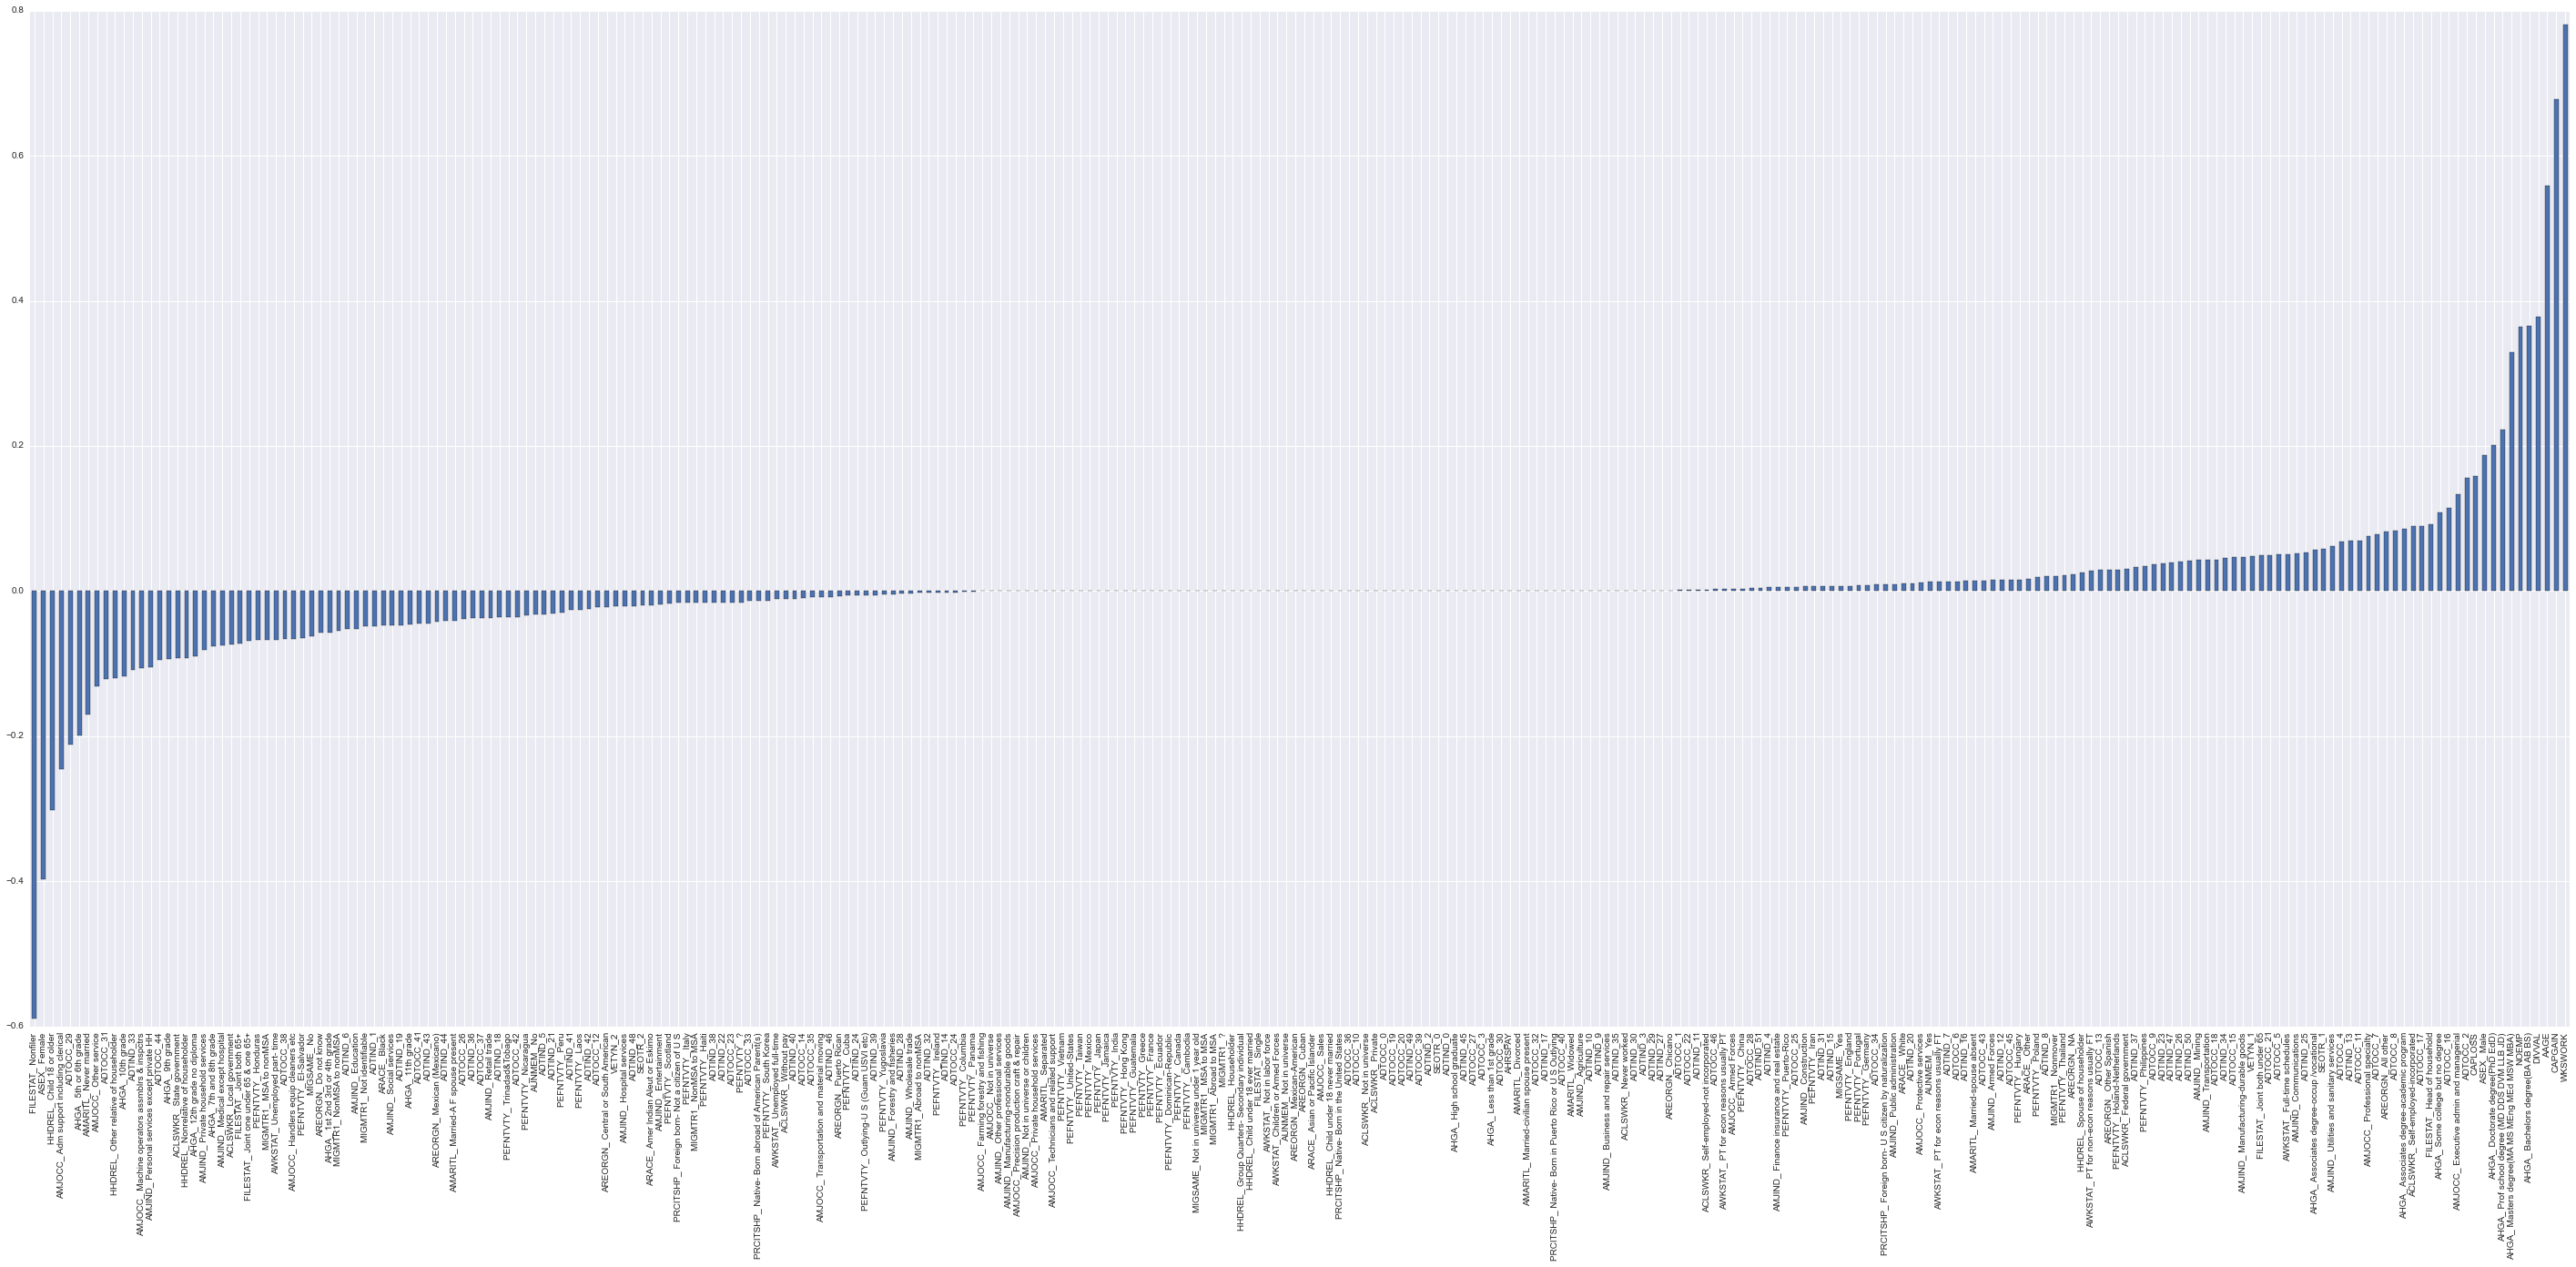

FILESTAT_ Nonfiler                              -0.589290
ASEX_ Female                                    -0.397475
HHDREL_ Child 18 or older                       -0.301473
AMJOCC_ Adm support including clerical          -0.244892
ADTOCC_29                                       -0.211220
AHGA_ 5th or 6th grade                          -0.199270
AMARITL_ Never married                          -0.170614
AMJOCC_ Other service                           -0.131780
ADTOCC_31                                       -0.121675
HHDREL_ Other relative of householder           -0.120330
AHGA_ 10th grade                                -0.117253
ADTIND_33                                       -0.108727
AMJOCC_ Machine operators assmblrs & inspctrs   -0.106234
AMJIND_ Personal services except private HH     -0.104943
ADTOCC_44                                       -0.094634
AHGA_ 9th grade                                 -0.093288
ACLSWKR_ State government                       -0.092133
HHDREL_ Nonrel

In [17]:
# PLOTTING LOGISTIC REGRESSION COEFFICIENTS

coefsl1 = pd.Series(logregl1_combined.coef_[0], index=trainX_combined.columns)
coefsl1.sort()

coefsl2 = pd.Series(logregl2_combined.coef_[0], index=trainX_combined.columns)
coefsl2.sort()

# sparsity with l1 regularization
zeros = coefsl1.value_counts()
if 0.0 in zeros:
    sparsity = zeros[0.0] / len(coefsl1.index)
else:
    sparsity = 0.0
print 'sparsity with l1: %f' % sparsity

# sparsity with l2 regularization
zeros = coefsl2.value_counts()
if 0.0 in zeros:
    sparsity = zeros[0.0] / len(coefsl2.index)
else:
    sparsity = 0.0
print 'sparsity with l2: %f' % sparsity

plt.figure(figsize=(50,20))
coefsl1.plot(kind="bar")
plt.show()

print coefsl1

# PLOTTING RANDOM FOREST FEATURES IMPORTANCE

importances = randfor_combined.feature_importances_
max10 = importances.argsort()[-10:][::-1]
print 'importance des features dans la random forest (ordre décroissant):'
print trainX_combined.columns[max10]



In [18]:
# TOTAL VARIABLES --> TESTING

test_data_cont_int = test_data_cont
dummies = pd.get_dummies(test_data_nom_ok, columns=test_data_nom_ok.columns)
test_data_nom_int = dummies
y_test = test_data.OUT

scaler = skl.preprocessing.StandardScaler()
testX_cont = pd.DataFrame(scaler.fit_transform(test_data_cont_int), columns=test_data_cont_int.columns)
testX_nom = pd.DataFrame(scaler.fit_transform(test_data_nom_int), columns=test_data_nom_int.columns)
testX_combined = pd.concat([testX_cont, testX_nom], axis=1)

testX_cont_bestchi2 = testX_cont.iloc[:, chi2filter_cont_index]
testX_nom_bestchi2 = testX_nom.iloc[:, chi2filter_nom_index]
testX_combined_bestchi2 = pd.concat([testX_cont_bestchi2, testX_nom_bestchi2], axis=1)

testX_combined_pca = pca_combined.transform(testX_combined)

poly = skl.preprocessing.PolynomialFeatures(degree=2)
testX_cont_pol = pd.DataFrame(poly.fit_transform(testX_cont))
testX_combined_pol = pd.concat([testX_cont_pol, testX_nom], axis=1)

precision, recall, f1score, _ = precision_recall_fscore_support(y_test, logregl1_combined.predict(testX_combined))
print 'Logistic regression l1: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])
precision, recall, f1score, _ = precision_recall_fscore_support(y_test, logregl2_combined.predict(testX_combined))
print 'Logistic regression l2: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])
precision, recall, f1score, _ = precision_recall_fscore_support(y_test, logreg_combined_bestchi2.predict(testX_combined_bestchi2))
print 'Logistic regression with best chi2: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])
precision, recall, f1score, _ = precision_recall_fscore_support(y_test, logreg_combined_pca.predict(testX_combined_pca))
print 'Logistic regression with pca: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])
precision, recall, f1score, _ = precision_recall_fscore_support(y_test, logreg_combined_pol.predict(testX_combined_pol))
print 'Logistic regression with PolynomialFeatures: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])
precision, recall, f1score, _ = precision_recall_fscore_support(y_test, randfor_combined.predict(testX_combined))
print 'Random forest: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])
precision, recall, f1score, _ = precision_recall_fscore_support(y_test, randfor_combined_oob.predict(testX_combined))
print 'Random forest with oob scores: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])
precision, recall, f1score, _ = precision_recall_fscore_support(y_test, extratrees_combined.predict(testX_combined))
print 'Extra trees: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])
precision, recall, f1score, _ = precision_recall_fscore_support(y_test, adaboost_combined.predict(testX_combined))
print 'Adaboost: precision = %f, recall = %f, f1score = %f' % (precision[1], recall[1], f1score[1])

Logistic regression l1: precision = 0.736874, recall = 0.397026, f1score = 0.516021
Logistic regression l2: precision = 0.730667, recall = 0.398642, f1score = 0.515846
Logistic regression with best chi2: precision = 0.720771, recall = 0.356773, f1score = 0.477292
Logistic regression with pca: precision = 0.672672, recall = 0.319916, f1score = 0.433611
Logistic regression with PolynomialFeatures: precision = 0.734904, recall = 0.403330, f1score = 0.520822
Random forest: precision = 0.732881, recall = 0.366796, f1score = 0.488903
Random forest with oob scores: precision = 0.729876, recall = 0.370837, f1score = 0.491800
Extra trees: precision = 0.647295, recall = 0.338506, f1score = 0.444539
Adaboost: precision = 0.693025, recall = 0.396702, f1score = 0.504575
